# Гипотезы о долях ушедших клиентов

In [54]:
import numpy as np
import scipy
import pandas as pd
import seaborn as sns
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
telecom_data = pd.read_csv('../../data/telecom_churn.csv')

In [3]:
telecom_data.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


**Посмотрим на средний отток клиентов среди тех, у кого подключен роуминг и у кого – нет.**

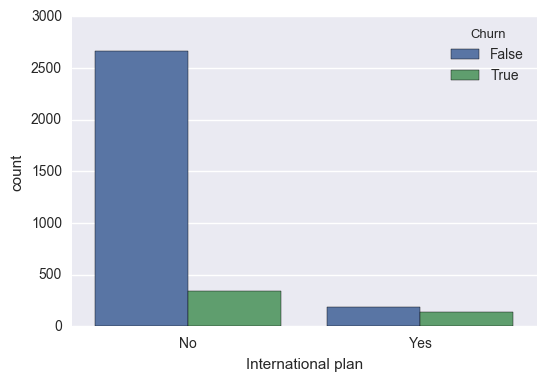

In [57]:
sns.countplot(x='International plan', hue='Churn', data=telecom_data);

In [8]:
churn_with_int_plan = telecom_data[telecom_data['International plan']
                                   == 'Yes']['Churn']
churn_no_int_plan = telecom_data[telecom_data['International plan']
                                   == 'No']['Churn']

In [10]:
churn_with_int_plan.mean(), churn_with_int_plan.std()

(0.42414860681114552, 0.49497989439961526)

In [11]:
churn_no_int_plan.mean(), churn_no_int_plan.std()

(0.11495016611295682, 0.31901478993881544)

**Построим для этих величин доверительные интервалы Уилсона.**

In [13]:
from statsmodels.stats.proportion import proportion_confint

In [14]:
wilson_interval1 = proportion_confint(sum(churn_with_int_plan), 
                                     len(churn_with_int_plan), 
                                      method = 'wilson')

In [16]:
print('wilson_interval for churn with international plan is [%f, %f] with width %f' 
      % (wilson_interval1[0], wilson_interval1[1],
         wilson_interval1[1] - wilson_interval1[0]))

wilson_interval for churn with international plan is [0.371454, 0.478626] with width 0.107173


In [17]:
wilson_interval2 = proportion_confint(sum(churn_no_int_plan), 
                                     len(churn_no_int_plan), 
                                      method = 'wilson')

In [18]:
print('wilson_interval for churn w/0 international plan is [%f, %f] with width %f' 
      % (wilson_interval2[0], wilson_interval2[1],
         wilson_interval2[1] - wilson_interval2[0]))

wilson_interval for churn w/0 international plan is [0.104043, 0.126839] with width 0.022796


**Проверим гипотезу о разности долей ушедших клиентов для тех, кто с роумингом и без (хотя уже все очевидно).**

In [46]:
def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

In [47]:
def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - scipy.stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return scipy.stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - scipy.stats.norm.cdf(z_stat)

In [53]:
print("p-value: %f" % proportions_diff_z_test(proportions_diff_z_stat_ind(
            churn_with_int_plan, churn_no_int_plan),
            alternative='greater'))

p-value: 0.000000


**Проверим гипотезу о разности долей ушедших клиентов для тех, кто обращался в сервисный центр более 3 раз и для тех, кто звонил в поддержку реже.**

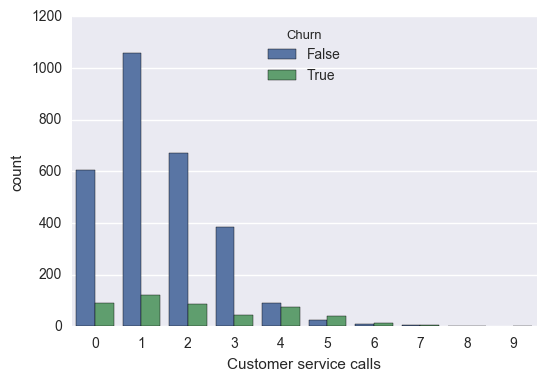

In [58]:
sns.countplot(x='Customer service calls', hue='Churn', data=telecom_data);

In [59]:
many_calls_churn = telecom_data[
                   telecom_data['Customer service calls'] > 3]['Churn']
less_calls_churn = telecom_data[
                   telecom_data['Customer service calls'] <= 3]['Churn']

In [62]:
print("p-value: %f" % proportions_diff_z_test(proportions_diff_z_stat_ind(
            many_calls_churn, less_calls_churn),
            alternative='greater'))

p-value: 0.000000


**Проверим гипотезу о равенстве средних проговоренных дневных минут среди ушедших и лояльных (внимание! это уже не гипотезы о долях, а гипотезы о средних для нормального распределения)**

In [64]:
from statsmodels.stats.weightstats import CompareMeans, DescrStatsW

In [65]:
churn_day_minutes = telecom_data[telecom_data['Churn'] == True]['Total day minutes']
loyal_day_minutes = telecom_data[telecom_data['Churn'] == False]['Total day minutes']

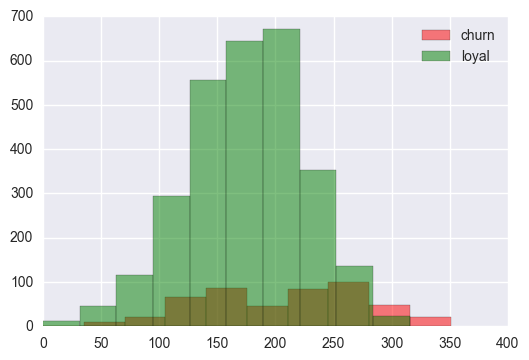

In [80]:
churn_day_minutes.hist(color='red', alpha=0.5, label='churn')
loyal_day_minutes.hist(color='green', alpha=0.5, label='loyal')
legend();

Воспользуемся реализацией t-теста из модуля statsmodels. Тут синтаксис немного отличается. Класс CompareMeans инициализируется двумя объектами DescrStatsW. DescrStatsW считает различные статистики по выборке, а CompareMeans имеет метод ttest_ind, реализующий t-тест на сравнение средних в независимых выборках.

In [66]:
cmp_means = CompareMeans(DescrStatsW(churn_day_minutes),
                         DescrStatsW(loyal_day_minutes))

In [73]:
cmp_means.ttest_ind(alternative='larger')

(12.097552860782955, 2.6501391137461471e-33, 3331.0)

Интересно, ушедшие клиенты больше наговаривают. Видимо, недовольны ценами.